In [1]:
import os
import os.path as osp
import pandas as pd
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.font_manager as fm
import seaborn as sns

In [2]:
from pathlib import Path
import pyrootutils

notebook_path = Path(os.path.abspath(""))
pyrootutils.setup_root(notebook_path, indicator=".project-root", pythonpath=True)

DIRNAME = r"/cluster/home/vjimenez/adv_pa_new/results"

In [3]:
LABEL_DICT = {
    "Standard": "Undefended",
    "Engstrom2019Robustness": "Engstrom et al.",
    "Wong2020Fast": "Wong et al.",
    "Addepalli2021Towards_RN18": "Addepalli et al.",
    "Wang2023Better_WRN-28-10": "Wang et al.", 
    "BPDA": "Athalye et al."
}

COLORS_DICT = {
    "Standard": "tab:orange",
    "Engstrom2019Robustness": "tab:blue",
    "BPDA": "tab:green",
    "Wong2020Fast": "tab:red",
    "Addepalli2021Towards_RN18": "tab:purple",
    "Wang2023Better_WRN-28-10": "tab:brown"
}
EPSILON_DICT = {
    "0.0314": "8 / 255",
    "0.0627": "16 / 255",
    "0.1255": "32 / 255"
}

In [4]:
import pickle

pkl_file = r"/cluster/home/vjimenez/adv_pa_new/results/adv/Wang2023Better_WRN-28-10/PGD_eps=0.0314_ar=1.0_histogram.pkl"
# pkl_file = r"/cluster/home/vjimenez/adv_pa_new/results/adv/Wang2023Better_WRN-28-10/FMN_ar=1.0_distributions.pkl"
with open(pkl_file, "rb") as f:
    posteriors_dict = pickle.load(f)


/cluster/project/jbuhmann/posterior_agreement/.venvs/adv_pa/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
posteriors_dict.keys()

dict_keys(['stored_orig_true', 'stored_orig_gibbs_true', 'stored_orig_false', 'stored_orig_gibbs_false', 'stored_adv_true', 'stored_adv_gibbs_true'])

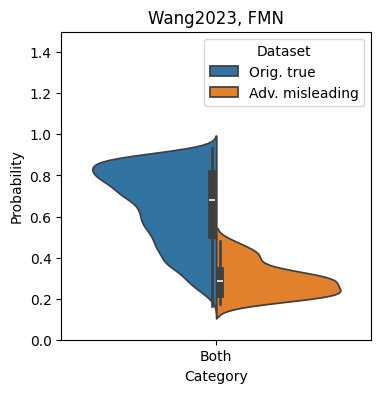

In [15]:
probs_dataset1 = posteriors_dict['stored_orig_true'][:,0].flatten()
probs_dataset2 = posteriors_dict['stored_adv_true'][:,0].flatten().clip(0.0, 1.0)

fig, ax = plt.subplots(figsize=(4,4))
# df = pd.DataFrame({
#     'Probability': np.concatenate([probs_dataset1, probs_dataset2]),
#     'Dataset': ['Dataset 1'] * len(probs_dataset1) + ['Dataset 2'] * len(probs_dataset2)
# })
# sns.violinplot(ax=ax, x='Dataset', y='Probability', data=df, split=False)

df = pd.DataFrame({
    'Probability': np.concatenate([probs_dataset1, probs_dataset2]),
    'Dataset': ["Orig. true"] * len(probs_dataset1) + ["Adv. misleading"] * len(probs_dataset2),
    'Category': ['Both'] * (len(probs_dataset1) + len(probs_dataset2))  # Same category for both datasets
})
sns.violinplot(
    ax=ax,
    x='Category',
    y='Probability',
    hue='Dataset',
    data=df,
    split=True,
)


ax.set_ylim([0.0,1.5])

# Show plot
plt.title("Wang2023, FMN")
plt.show()

# GENERATION OF THE FINAL PLOTS

## Obtaining dataframe

In [5]:
def get_violin_df(
        attack_name: str,
        epsilon: str,
        ar: str = "1.0",
    ):

    # Getting the data ------------------------------------------------------------------------------------------------
    probs = []
    for defense in LABEL_DICT.keys():
        if attack_name == "PGD":
            pkl_file = rf"/cluster/home/vjimenez/adv_pa_new/results/adv/{defense}/PGD_eps={epsilon}_ar={ar}_histogram.pkl"
        else:
            pkl_file = rf"/cluster/home/vjimenez/adv_pa_new/results/adv/{defense}/FMN_ar={ar}_histogram.pkl"
        with open(pkl_file, "rb") as f:
            posteriors_dict = pickle.load(f)

        # probs.extend([
        #     posteriors_dict['stored_orig_true'][:,0].flatten().clip(0.0, 1.0),
        #     posteriors_dict['stored_orig_gibbs_true'][:,0].flatten().clip(0.0, 1.0),
        #     posteriors_dict['stored_orig_false'][:,0].flatten().clip(0.0, 1.0),
        #     posteriors_dict['stored_orig_gibbs_false'][:,0].flatten().clip(0.0, 1.0),
        #     posteriors_dict['stored_adv_true'][:,0].flatten().clip(0.0, 1.0),
        #     posteriors_dict['stored_adv_gibbs_true'][:,0].flatten().clip(0.0, 1.0)
        # ])
        probs.extend([
            posteriors_dict['stored_orig_true'][:,0].flatten().clip(0.0, 1.0),
            posteriors_dict['stored_orig_gibbs_false'][:,0].flatten().clip(0.0, 1.0),
            
            posteriors_dict['stored_adv_true'][:,0].flatten().clip(0.0, 1.0),
            posteriors_dict['stored_orig_gibbs_true'][:,0].flatten().clip(0.0, 1.0),
            
            posteriors_dict['stored_orig_false'][:,0].flatten().clip(0.0, 1.0),
            posteriors_dict['stored_adv_gibbs_true'][:,0].flatten().clip(0.0, 1.0)
        ])

    list_defenses = list(LABEL_DICT.values())
    subsets = ["orig_true", "orig_false", "adv_true"]
    df = pd.DataFrame({
        'probability': np.concatenate(probs),
        'defense': [
            list_defenses[p//6]
            for p, prob in enumerate(probs)
            for _ in range(len(prob))
        ],
        'beta': [
            r"$\beta = 1$" if p%2 == 0 else r"$\beta = \beta^*$"
            for p, prob in enumerate(probs)
            for _ in range(len(prob))
            
        ],
        'subset': [
            subsets[p%len(subsets)]
            for p, prob in enumerate(probs)
            for _ in range(len(prob))
        ]
    })

    return df

In [272]:
df = get_violin_df(
        attack_name = "FMN",
        epsilon = "0.0314",
        ar = "0.5",
)

In [273]:
df.head()

,probability,defense,beta,subset
0,0.999977,Undefended,$\beta = 1$,orig_true
1,1.000000,Undefended,$\beta = 1$,orig_true
2,0.999998,Undefended,$\beta = 1$,orig_true
3,0.999956,Undefended,$\beta = 1$,orig_true
4,0.996470,Undefended,$\beta = 1$,orig_true


## Checking dataframe

In [274]:
df_plot = df.loc[
    (df['defense'] == LABEL_DICT["Wang2023Better_WRN-28-10"]) &
    (df['beta'] == r"$\beta = 1$") &
    (df['subset'] == "adv_true")
]

df_plot.count()

probability    2070
defense        2070
beta           2070
subset         2070
dtype: int64

## Defense plot

In [6]:
import matplotlib.patches as patches

def defense_violin(
        df,
        defense: str,
        savedir: str,
        save: bool = False
    ):

    df_plot = df.loc[
        (df['defense'] == LABEL_DICT[defense])
    ]
    

    fontname = "DejaVu Serif"
    _ = fm.findfont(fm.FontProperties(family=fontname))

    # Create a line plot for PGD attack type with Seaborn
    _, ax = plt.subplots(figsize=(1.2 * 3.861, 2 * 2.7291))
    sns.set(font_scale=1.9)
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = fontname
    sns.set_style("ticks")

    # sns.violinplot(
    #     ax=ax,
    #     x='subset',
    #     y='probability',
    #     hue='beta',
    #     data=df_plot,
    #     split=True,
    # )

    CUSTOM_PALETTE = {
        r"$\beta = 1$": COLORS_DICT[defense],
        r"$\beta = \beta^*$": COLORS_DICT[defense]
    }

    sns.violinplot(
        ax=ax,
        x='subset',
        y='probability',
        hue='beta',
        data=df_plot,
        split=True,
        density_norm='width',
        linewidth=0,
        palette=CUSTOM_PALETTE,
        alpha=1,

        # Parameters of KDE
        # bw=0.1,
        cut=0
    )

    # Overlay hatching for beta=0 (right side)
    for icol, collection in enumerate(ax.collections): 
        if icol in [1,3,5,6,7,8,9,10,11,12,13,14,15]:
            collection.set_alpha(0.6)
            for path in collection.get_paths():
                hatch_patch = patches.PathPatch(
                    path, hatch="/", facecolor='none', lw=0,
                    edgecolor="white", alpha=0.6
                )
                ax.add_patch(hatch_patch)

    # Overlay the mean and std
    means = df_plot.groupby(['subset', 'beta'])['probability'].mean().reset_index()
    stds = df_plot.groupby(['subset', 'beta'])['probability'].std().reset_index()
    for i, subset in enumerate(df_plot['subset'].unique()):
        for j, beta in enumerate(df_plot['beta'].unique()):
            # Get the mean and std for this combination of subset and beta
            mean_val = means.loc[(means['subset'] == subset) & (means['beta'] == beta), 'probability'].values[0].clip(0.0, 1.0)
            std_val = stds.loc[(stds['subset'] == subset) & (stds['beta'] == beta), 'probability'].values[0]

            x_pos = i
            if beta == r"$\beta = 1$":
                x_pos -= 0.15  # Move left for beta=1
            else:
                x_pos += 0.15  # Move right for beta=0

            ax.scatter(x_pos, mean_val, color='black', marker='o', s=30, zorder=3)
            ax.errorbar(
                x_pos,
                mean_val,
                # yerr=std_val,
                yerr=np.asarray([
                    [std_val, std_val] if mean_val+std_val <= 1 else [std_val, 1-mean_val]
                ]).T,
                fmt='none',
                ecolor='black',
                capsize=3,
            )

    ax.set_xticklabels([
        r"$\hat{y}^\prime = y}$" + "\n" + r"$\mathbf{x}^\prime$",
        r"$\hat{y}^\prime \neq y}$" + "\n" + r"$\mathbf{x}^\prime$",
        r"$\hat{y}^{\prime\prime} \neq \hat{y}^\prime}$" + "\n" + r"$\mathbf{x}^{\prime \prime}$"
    ])

    ax.set_ylim(-0.15, 1.05)
    ax.set_ylabel(r"Conditional $\mathbf{P}(\hat{y})$", fontname=fontname)
    ax.set_xlabel(None)
    ax.set_title(LABEL_DICT[defense], fontname=fontname)

    ax.tick_params(axis="x", which="both", length=0)
    # plt.xticks(rotation=45)
    xticks_font = fm.FontProperties(family=fontname)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(xticks_font)
        tick.set_fontsize(16)

    ax.grid(linestyle="--")

    handles, labels = ax.get_legend_handles_labels()
    handles = [
        handles[0],
        ax.bar([0], [-10], bottom=[-5], width=0.4, alpha=0.6, hatch="/", color=COLORS_DICT[defense]) 
    ]
    
    # labels = [LABEL_DICT[label] for label in labels]
    ax.legend(
        handles,
        labels,
        loc="lower left",
        handlelength=1.0,
        prop={
            "family": fontname,
            'size': 14
        }  
    )

    plt.tight_layout()
    if save:
        fname = osp.join(
            savedir, 
            f"{defense}_violin_PGD_eps=0.1255_ar=1.0_beta" + ".pdf"
            # f"{defense}_violin_FMN_ar=0.5_beta" + ".pdf"
        )
        plt.savefig(fname, dpi=300)
        plt.clf()
    else:
        plt.show()
    plt.close()


In [21]:
LABEL_DICT.keys()

dict_keys(['Standard', 'Engstrom2019Robustness', 'Wong2020Fast', 'Addepalli2021Towards_RN18', 'Wang2023Better_WRN-28-10', 'BPDA'])

In [290]:
df = get_violin_df(
        attack_name = "PGD",
        epsilon = "0.1255",
        ar = "1.0",
)

/tmp/ipykernel_1653404/3371568240.py:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([


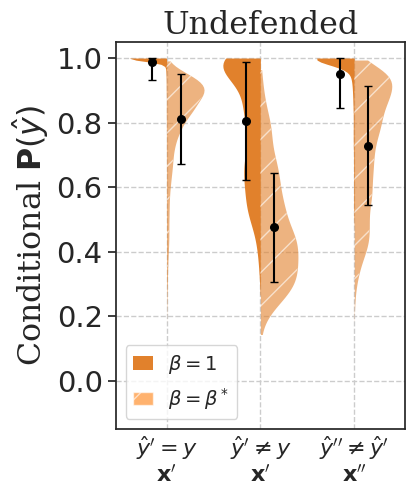

In [291]:
defense_violin(
    df=df,
    defense="Standard",
    savedir = "foo",
    save = False
)

En massa:

In [48]:
df = get_violin_df(
        attack_name = "PGD",
        epsilon = "0.1255",
        ar = "1.0",
)

In [49]:
for defense in LABEL_DICT.keys():
    defense_violin(
    df=df,
    defense=defense,
    savedir = osp.join("/cluster/home/vjimenez/adv_pa_new/results/adv", defense),
    save = False
)

/tmp/ipykernel_1443858/3371568240.py:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([
/tmp/ipykernel_1443858/3371568240.py:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([
/tmp/ipykernel_1443858/3371568240.py:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([
/tmp/ipykernel_1443858/3371568240.py:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([
/tmp/ipykernel_1443858/3371568240.py:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([
/tmp/ipykernel_1443858/3371568240.py:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([


## Attack plot

In [277]:
df.head()

,probability,defense,beta,subset
0,0.999977,Undefended,$\beta = 1$,orig_true
1,1.000000,Undefended,$\beta = 1$,orig_true
2,0.999998,Undefended,$\beta = 1$,orig_true
3,0.999956,Undefended,$\beta = 1$,orig_true
4,0.996470,Undefended,$\beta = 1$,orig_true


In [24]:
import matplotlib.patches as patches

def attack_violin(
        df,
        attack_name: str,
        epsilon: str,
        ar: str,
        savedir: str,
        save: bool = False
    ):
    df_plot = df.loc[
        (df["subset"].isin(["orig_true", "adv_true"])) & 
        (df["beta"] == r"$\beta = 1$")
    ]

    fontname = "DejaVu Serif"
    _ = fm.findfont(fm.FontProperties(family=fontname))

    # Create a line plot for PGD attack type with Seaborn
    _, ax = plt.subplots(figsize=(0.5 * 6 * 3.861, 2 * 2.7291))
    sns.set(font_scale=1.9)
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = fontname
    sns.set_style("ticks")


    # CUSTOM_PALETTE = {LABEL_DICT[k]: COLORS_DICT[k] for k in LABEL_DICT.keys()}
    for idef, (defense_key, defense_val) in enumerate(LABEL_DICT.items()):
        df_plot_i = df_plot[df_plot['defense'] == defense_val].copy()
        df_plot_i["index"] = idef
        CUSTOM_PALETTE = {
            "orig_true": COLORS_DICT[defense_key],
            "adv_true": COLORS_DICT[defense_key]
        }
        sns.violinplot(
            ax=ax,
            native_scale=True,
            x=df_plot_i["index"],
            y=df_plot_i['probability'],
            hue=df_plot_i['subset'],
            # data=df_plot_i,
            split=True,
            density_norm='width',
            linewidth=0,
            palette=CUSTOM_PALETTE,
            alpha=1,
            legend=False,

            # Parameters of KDE
            # bw=0.1,
            cut=0,
        )

        # Overlay the mean and std
        means = df_plot_i.groupby(['subset'])['probability'].mean().reset_index()
        stds = df_plot_i.groupby(['subset'])['probability'].std().reset_index()
        for i, subset in enumerate(df_plot_i['subset'].unique()):
            # Get the mean and std for this combination of subset and beta
            mean_val = means.loc[(means['subset'] == subset), 'probability'].values[0].clip(0.0, 1.0)
            std_val = stds.loc[(stds['subset'] == subset), 'probability'].values[0]

            x_pos = idef - ((-1)**i)*0.15
            ax.scatter(x_pos, mean_val, color='black', marker='o', s=30, zorder=3)
            ax.errorbar(
                x_pos,
                mean_val,
                # yerr=std_val,
                yerr=np.asarray([
                    [std_val, std_val] if mean_val+std_val <= 1 else [std_val, 1-mean_val]
                ]).T,
                fmt='none',
                ecolor='black',
                capsize=3,
            )

    # Overlay hatching for beta=0 (right side)
    for icol, collection in enumerate(ax.collections): 
        if icol in [1, 5, 7,11,13,17,19,21,23,25,27,29,31,33]:
            collection.set_alpha(0.6)
            for path in collection.get_paths():
                hatch_patch = patches.PathPatch(
                    path, hatch="/", facecolor='none', lw=0,
                    edgecolor="white", alpha=0.6
                )
                ax.add_patch(hatch_patch)

            
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_ylim(0.0, 1.05)
    # ax.set_ylabel(r"Conditional $\mathbf{P}(\hat{y})$", fontname=fontname)
    ax.set_ylabel(r"Predictive confidence", fontname=fontname)
    ax.set_xlabel(None)
    if attack_name == "PGD":
        ax.set_title(rf"PGD, AR = {ar}, $\ell_\infty$ = {EPSILON_DICT[epsilon]}", fontname=fontname)
    else:
        ax.set_title(f"FMN, AR = {ar}", fontname=fontname)

    ax.tick_params(axis="both", which="both", direction="in")
    # plt.xticks(rotation=45)
    xticks_font = fm.FontProperties(family=fontname)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(xticks_font)
        tick.set_fontsize(16)

    ax.grid(linestyle="--")

    handles, _ = ax.get_legend_handles_labels()
    handles = [
        ax.bar([0], [-10], bottom=[-5], width=0.4, alpha=1.0, color="grey"),
        ax.bar([0], [-10], bottom=[-5], width=0.4, alpha=0.6, hatch="/", color="grey") 
    ]
    # labels = [
    #     r"$\mathbf{P}(\hat{y}^\prime \mid \hat{y}^\prime = y)$",
    #     r"$\mathbf{P}(\hat{y}^{\prime \prime} \mid \hat{y}^{\prime \prime} \neq \hat{y}^\prime)$"
    # ]
    labels = [
        r"$p(\hat{y}^\prime \mid X^\prime, \hat{y}^\prime = y)$",
        r"$p(\hat{y}^{\prime \prime} \mid X^{\prime \prime}, \hat{y}^{\prime \prime} \neq \hat{y}^\prime)$"
    ]

    
    # labels = [LABEL_DICT[label] for label in labels]
    ax.legend(
        handles,
        labels,
        loc="upper right",
        handlelength=1.0,
        prop={
            "family": fontname,
            'size': 14
        }  
    )

    plt.tight_layout()
    if save:
        if attack_name == "PGD":
            fname = osp.join(
                savedir, 
                f"violin_PGD_eps={epsilon}_ar={ar}" + ".pdf"
            )
        else:
            fname = osp.join(
                savedir, 
                f"violin_FMN_ar={ar}" + ".pdf"
            )
        plt.savefig(fname, dpi=300)
        plt.clf()
    else:
        plt.show()
    plt.close()


In [45]:
# attack_name="FMN"
# epsilon=None
# ar="0.5"

attack_name="PGD"
epsilon="0.1255"
ar="1.0"

In [46]:
df = get_violin_df(
        attack_name=attack_name,
        epsilon=epsilon,
        ar=ar,
)

In [47]:
attack_violin(
    df=df,
    attack_name=attack_name,
    epsilon=epsilon,
    ar=ar,
    savedir=r"/cluster/home/vjimenez/adv_pa_new/results/adv",
    save=True
)

In [313]:
import matplotlib.patches as patches

def attack_violin_3(
        df,
        attack_name:str,
        epsilon:str,
        ar:str,
        appendix:str,
        savedir: str,
        save: bool = False
    ):
    SELECTED_DEFENSES = ['Undefended', 'Wang et al.', 'Athalye et al.']
    df_plot = df.loc[
        (df["defense"].isin(SELECTED_DEFENSES)) &
        (df["subset"].isin(["orig_true", "adv_true"])) & 
        (df["beta"] == r"$\beta = 1$")
    ]

    fontname = "DejaVu Serif"
    _ = fm.findfont(fm.FontProperties(family=fontname))

    # Create a line plot for PGD attack type with Seaborn
    _, ax = plt.subplots(figsize=(0.5 * 3 * 3.861, 2 * 2.7291))
    sns.set(font_scale=1.9)
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = fontname
    sns.set_style("ticks")


    INVERTED_LABEL_DICT = {v: k for k, v in LABEL_DICT.items()}
    for idef, defense_val in enumerate(SELECTED_DEFENSES):
        defense_key = INVERTED_LABEL_DICT[defense_val]
        df_plot_i = df_plot[df_plot['defense'] == defense_val].copy()
        df_plot_i["index"] = idef
        CUSTOM_PALETTE = {
            "orig_true": COLORS_DICT[defense_key],
            "adv_true": COLORS_DICT[defense_key]
        }
        sns.violinplot(
            ax=ax,
            native_scale=True,
            x=df_plot_i["index"],
            y=df_plot_i['probability'],
            hue=df_plot_i['subset'],
            # data=df_plot_i,
            split=True,
            density_norm='width',
            linewidth=0,
            palette=CUSTOM_PALETTE,
            alpha=1,
            legend=False,

            # Parameters of KDE
            # bw=0.1,
            cut=0,
        )

        # Overlay the mean and std
        means = df_plot_i.groupby(['subset'])['probability'].mean().reset_index()
        stds = df_plot_i.groupby(['subset'])['probability'].std().reset_index()
        for i, subset in enumerate(df_plot_i['subset'].unique()):
            # Get the mean and std for this combination of subset and beta
            mean_val = means.loc[(means['subset'] == subset), 'probability'].values[0].clip(0.0, 1.0)
            std_val = stds.loc[(stds['subset'] == subset), 'probability'].values[0]

            x_pos = idef - ((-1)**i)*0.15
            ax.scatter(x_pos, mean_val, color='black', marker='o', s=30, zorder=3)
            ax.errorbar(
                x_pos,
                mean_val,
                # yerr=std_val,
                yerr=np.asarray([
                    [std_val, std_val] if mean_val+std_val <= 1 else [std_val, 1-mean_val]
                ]).T,
                fmt='none',
                ecolor='black',
                capsize=3,
            )

    # Overlay hatching for beta=0 (right side)
    for icol, collection in enumerate(ax.collections): 
        if icol in [1, 5, 7,11,13,17,19,21,23,25,27,29,31,33]:
            collection.set_alpha(0.6)
            for path in collection.get_paths():
                hatch_patch = patches.PathPatch(
                    path, hatch="/", facecolor='none', lw=0,
                    edgecolor="white", alpha=0.6
                )
                ax.add_patch(hatch_patch)

            
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_ylim(0.0, 1.05)
    ax.set_ylabel(r"Predictive confidence", fontname=fontname)
    ax.set_xlabel(None)

    if attack_name == "FMN":
        ax.set_title(rf"FMN, AR = {ar}", fontname=fontname)
    else:
        ax.set_title(rf"PGD, AR = {ar}, $\ell_\infty$ = {EPSILON_DICT[epsilon]}", fontname=fontname)

    ax.tick_params(axis="both", which="both", direction="in")
    # plt.xticks(rotation=45)
    xticks_font = fm.FontProperties(family=fontname)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(xticks_font)
        tick.set_fontsize(16)

    ax.grid(linestyle="--")

    handles, _ = ax.get_legend_handles_labels()
    handles = [
        ax.bar([0], [-10], bottom=[-5], width=0.4, alpha=1.0, color="grey"),
        ax.bar([0], [-10], bottom=[-5], width=0.4, alpha=0.6, hatch="/", color="grey") 
    ]
    # labels = [
    #     r"$\mathbf{P}(\hat{y}^\prime \mid \hat{y}^\prime = y)$",
    #     r"$\mathbf{P}(\hat{y}^{\prime \prime} \mid \hat{y}^{\prime \prime} \neq \hat{y}^\prime)$"
    # ]
    labels = [
        r"$p(\hat{y}^\prime \mid X^\prime, \hat{y}^\prime = y)$",
        r"$p(\hat{y}^{\prime \prime} \mid X^{\prime \prime}, \hat{y}^{\prime \prime} \neq \hat{y}^\prime)$"
    ]

    
    # labels = [LABEL_DICT[label] for label in labels]
    ax.legend(
        handles,
        labels,
        loc="upper right",
        handlelength=1.0,
        prop={
            "family": fontname,
            'size': 13
        }  
    )

    plt.tight_layout()
    if save:
        if attack_name=="PGD":
            fname = osp.join(
                savedir, 
                f"violin_3_PGD_eps={epsilon}_ar={ar}_{appendix}" + ".pdf"
            )
        else:
            fname = osp.join(
                savedir, 
                f"violin_3_FMN_ar={ar}_{appendix}" + ".pdf"
            )
        plt.savefig(fname, dpi=300)
        plt.clf()
    else:
        plt.show()
    plt.close()


In [363]:
ar="1.0"

attack_name="PGD"
epsilon="0.1255"

attack_name="FMN"
epsilon=None

In [364]:
df = get_violin_df(
    attack_name=attack_name,
    epsilon=epsilon,
    ar=ar,
)

In [366]:
attack_violin_3(
    df=df,
    attack_name=attack_name,
    epsilon=epsilon,
    ar=ar,
    appendix="diffclass",
    savedir=r"/cluster/home/vjimenez/adv_pa_new/results/adv/",
    save=True
)

# FULL POSTERIOR VIOLINS

In [3]:
import pickle

In [224]:
def get_violin_df_posteriors(
        dfname: str,
        attack_name: str,
        epsilon: str = None,
        ar: str = "1.0",
    ):

    # Getting the data ------------------------------------------------------------------------------------------------
    probs = []
    for defense in LABEL_DICT.keys():
        if attack_name == "PGD":
            pkl_file = rf"/cluster/home/vjimenez/adv_pa_new/results/adv/{defense}/PGD_eps={epsilon}_ar={ar}_{dfname}.pkl"
        else:
            pkl_file = rf"/cluster/home/vjimenez/adv_pa_new/results/adv/{defense}/FMN_ar={ar}_{dfname}.pkl"
        with open(pkl_file, "rb") as f:
            posteriors_dict = pickle.load(f)

        probs.extend([
            posteriors_dict['stored_x'].clip(0.0, 1.0),
            posteriors_dict['stored_x_gibbs'].clip(0.0, 1.0),

            posteriors_dict['stored_xprime'].clip(0.0, 1.0),
            posteriors_dict['stored_xprime_gibbs'].clip(0.0, 1.0),
        ])

    list_defenses = list(LABEL_DICT.values())
    subsets = ["x", "x", "xprime", "xprime"]
    df = pd.DataFrame({
        'probability': np.concatenate(probs),
        'defense': [
            list_defenses[p//4]
            for p, prob in enumerate(probs)
            for _ in range(len(prob))
        ],
        'beta': [
            r"$\beta = 1$" if p%2 == 0 else r"$\beta = \beta^*$"
            for p, prob in enumerate(probs)
            for _ in range(len(prob))
            
        ],
        'subset': [
            subsets[p%len(subsets)]
            for p, prob in enumerate(probs)
            for _ in range(len(prob))
        ]
    })

    return df

In [189]:
df = get_violin_df_posteriors(
    dfname="histogram_posteriors_trueclass",
    attack_name="FMN",
    # epsilon="0.0314",
    ar="1.0",
)

In [190]:
df.head()

,probability,defense,beta,subset
0,0.999990,Undefended,$\beta = 1$,x
1,0.999999,Undefended,$\beta = 1$,x
2,0.999965,Undefended,$\beta = 1$,x
3,0.996804,Undefended,$\beta = 1$,x
4,0.999975,Undefended,$\beta = 1$,x


In [142]:
df["subset"].value_counts()

x         120192
xprime    119808
Name: subset, dtype: int64

In [14]:
LABEL_DICT

{'Standard': 'Undefended',
 'Engstrom2019Robustness': 'Engstrom et al.',
 'Wong2020Fast': 'Wong et al.',
 'Addepalli2021Towards_RN18': 'Addepalli et al.',
 'Wang2023Better_WRN-28-10': 'Wang et al.',
 'BPDA': 'Athalye et al.'}

In [340]:
import matplotlib.patches as patches
def attack_violin_posteriors(
        df,
        attack_name: str,
        epsilon: str,
        ar: str,
        savedir: str,
        appendix: str,
        save: bool = False
    ):
    SELECTED_DEFENSES = ['Undefended', 'Wang et al.', 'Athalye et al.']
    # SELECTED_DEFENSES = ['Undefended', 'Engstrom et al.', 'Wong et al.', 'Addepalli et al.', 'Wang et al.', 'Athalye et al.']

    df_plot = df.loc[
        (df["defense"].isin(SELECTED_DEFENSES)) & (df["beta"]==r"$\beta = 1$")
        # (df["beta"]==r"$\beta = \beta^*$")
    ]
    fontname = "DejaVu Serif"
    _ = fm.findfont(fm.FontProperties(family=fontname))

    # Create a line plot for PGD attack type with Seaborn
    _, ax = plt.subplots(figsize=(0.5 * len(SELECTED_DEFENSES) * 3.861, 2 * 2.7291))
    sns.set(font_scale=1.9)
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = fontname
    sns.set_style("ticks")

    INVERTED_LABEL_DICT = {v: k for k, v in LABEL_DICT.items()}
    for idef, defense_val in enumerate(SELECTED_DEFENSES):
        defense_key = INVERTED_LABEL_DICT[defense_val]
        df_plot_i = df_plot[df_plot['defense'] == defense_val].copy()
        df_plot_i["index"] = float(idef)

        CUSTOM_PALETTE = {
            "x": COLORS_DICT[defense_key],
            "xprime": COLORS_DICT[defense_key]
        }
        sns.violinplot(
            ax=ax,
            native_scale=True,
            x=df_plot_i["index"],
            y=df_plot_i['probability'],
            hue=df_plot_i['subset'],
            # data=df_plot_i,
            split=True,
            density_norm='width',# area, count, width
            linewidth=0,
            palette=CUSTOM_PALETTE,
            alpha=1,
            legend=False,

            # Parameters of KDE
            # bw_adjust=2.5,
            cut=0,
        )

        # Overlay the mean and std
        means = df_plot_i.groupby(['subset'])['probability'].mean().reset_index()
        stds = df_plot_i.groupby(['subset'])['probability'].std().reset_index()
        for i, subset in enumerate(df_plot_i['subset'].unique()):
            # Get the mean and std for this combination of subset and beta
            mean_val = means.loc[(means['subset'] == subset), 'probability'].values[0].clip(0.0, 1.0)
            std_val = stds.loc[(stds['subset'] == subset), 'probability'].values[0]

            x_pos = idef - ((-1)**i)*0.15
            ax.scatter(x_pos, mean_val, color='black', marker='o', s=30, zorder=3)
            ax.errorbar(
                x_pos,
                mean_val,
                # yerr=std_val,
                yerr=np.asarray([
                    [std_val, std_val] if mean_val+std_val <= 1 else [std_val, 1-mean_val]
                ]).T,
                fmt='none',
                ecolor='black',
                capsize=3,
            )

    # Overlay hatching for beta=0 (right side)
    for icol, collection in enumerate(ax.collections): 
        if icol in [1, 7, 13]:
            collection.set_alpha(0.6)
            for path in collection.get_paths():
                hatch_patch = patches.PathPatch(
                    path, hatch="/", facecolor='none', lw=0,
                    edgecolor="white", alpha=0.6
                )
                ax.add_patch(hatch_patch)

            
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_ylim(0.0, 1.05)
    # ax.set_ylabel(r"Conditional $\mathbf{P}(\hat{y})$", fontname=fontname)
    ax.set_ylabel(r"Predictive confidence", fontname=fontname)
    ax.set_xlabel(None)

    if attack_name == "FMN":
        ax.set_title(rf"FMN, AR = {ar}", fontname=fontname)
    else:
        ax.set_title(rf"PGD, AR = {ar}, $\ell_\infty$ = {EPSILON_DICT[epsilon]}", fontname=fontname)
    # ax.set_title(r"FMN, AR = 0.5", fontname=fontname)

    ax.tick_params(axis="both", which="both", direction="in")
    xticks_font = fm.FontProperties(family=fontname)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(xticks_font)
        tick.set_fontsize(16)

    ax.grid(linestyle="--")

    handles, _ = ax.get_legend_handles_labels()
    handles = [
        ax.bar([0], [-10], bottom=[-5], width=0.4, alpha=1.0, color="grey"),
        ax.bar([0], [-10], bottom=[-5], width=0.4, alpha=0.6, hatch="/", color="grey") 
    ]
    # labels = [
    #     r"$\mathbf{P}(y \mid \hat{y}^\prime = y)$",
    #     r"$\mathbf{P}(y \mid \hat{y}^{\prime \prime} \neq \hat{y}^\prime)$"
    # ]
    labels = [
        r"$p(y \mid X^\prime, \hat{y}^\prime \neq  \hat{y}^{\prime \prime})$",
        r"$p(y \mid X^{\prime \prime}, \hat{y}^\prime \neq  \hat{y}^{\prime \prime})$"
    ]

    
    ax.legend(
        handles,
        labels,
        loc="upper right",
        handlelength=1.0,
        prop={
            "family": fontname,
            'size': 13
        }  
    )

    plt.tight_layout()
    if save:
        if attack_name=="PGD":
            fname = osp.join(
                savedir, 
                f"violin_3_PGD_eps={epsilon}_ar={ar}_{appendix}" + ".pdf"
            )
        else:
            fname = osp.join(
                savedir, 
                f"violin_3_FMN_ar={ar}_{appendix}" + ".pdf"
            )
        plt.savefig(fname, dpi=300)
        plt.clf()
    else:
        plt.show()
    plt.close()


In [353]:
ar="0.5"

# attack_name="PGD"
# epsilon="0.0314"

attack_name="FMN"
epsilon=None

In [354]:
df = get_violin_df_posteriors(
    dfname="histogram_posteriors_trueclass",
    attack_name=attack_name,
    epsilon=epsilon,
    ar=ar,
)

In [355]:
attack_violin_posteriors(
    df=df,
    attack_name=attack_name,
    epsilon=epsilon,
    ar=ar,
    appendix="trueclass",
    savedir=r"/cluster/home/vjimenez/adv_pa_new/results/adv/",
    save=False
)